## Multiple Linear Regression 
### Bike sharing assignment

#### Problem Statement:
Build a multiple linear regression model for the prediction of demand for shared bikes.
The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

## PRELIMINARY 
### PERFORM EDA AND DATA UNDERSTANDING 

#### IGNORE WARNING

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

#### IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### READING THE DATA CSV

In [3]:
data = pd.read_csv(r'day.csv')
pd.set_option('max_columns', None)
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### NUMBER OF ROWS AND COLUMNS IN DATASET

In [4]:
rows, columns = data.shape
print(f'The dataset has {rows} rows and {columns} columns')

The dataset has 730 rows and 16 columns


#### BASIC INFO ON THE DATASET 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
# Looking for data duplicates
row, column = data[data.duplicated()].shape
print('There are no duplicates in the dataset.' if row==0 else f'There are {row} duplicates in the dataset.')

There are no duplicates in the dataset.


#### NUMBER OF FEATURES AND PERCENTAGE OF NULL VALUES

In [7]:
# number of numerical and categorical features
num, obj = 0, 0
for feature in data:
    if data[feature].dtype == 'O':
        obj += 1
    else:
        num += 1
print('NUMBER OF NUMERICAL AND CATEGORICAL FEATURES:')
print(f'The dataset has {num} numerical features and {obj} categorical features')

# Percentage of missing values
print('\nPERCENTAGE MISSING VALUES AFTER FILLING:')
c=0
for feature in data:
    if data[feature].isnull().sum()!=0:
        print(f"The feature '{feature}' has {np.round((data[feature].isnull().mean()*100),2)}% missing values")
    else:
        c+=1
if c == len(data.columns):print('There is no missing values in the dataset')

NUMBER OF NUMERICAL AND CATEGORICAL FEATURES:
The dataset has 15 numerical features and 1 categorical features

PERCENTAGE MISSING VALUES AFTER FILLING:
There is no missing values in the dataset


#### INFERENCE ON DROP OF IRRELAVANT COLUMNS




- The feature <b>'instant'</b> has no significance in prediction of demand of bikes.
- The feature <b>'dteday'</b> has significance but the same column can be derived from following features 'season	yr	mnth	weekday	'.
- The feature <b>casual & registered</b> this feature has no much significance as we are interested in total count of bikes (ie demand) not by category wise and moreover combination of casual & registered is target 'cnt'. 
- The feature <b>holiday</b> is dropped as it can be deduced by feature 'workingday'



Hence above highlighted  columns will be dropped.

In [8]:
## dropping the decided columns 
del data['instant']
del data['dteday']
del data['casual']
del data['registered']
del data['holiday']

In [9]:
rows, columns = data.shape
print(f'The dataset has {rows} rows and {columns} columns')

The dataset has 730 rows and 11 columns


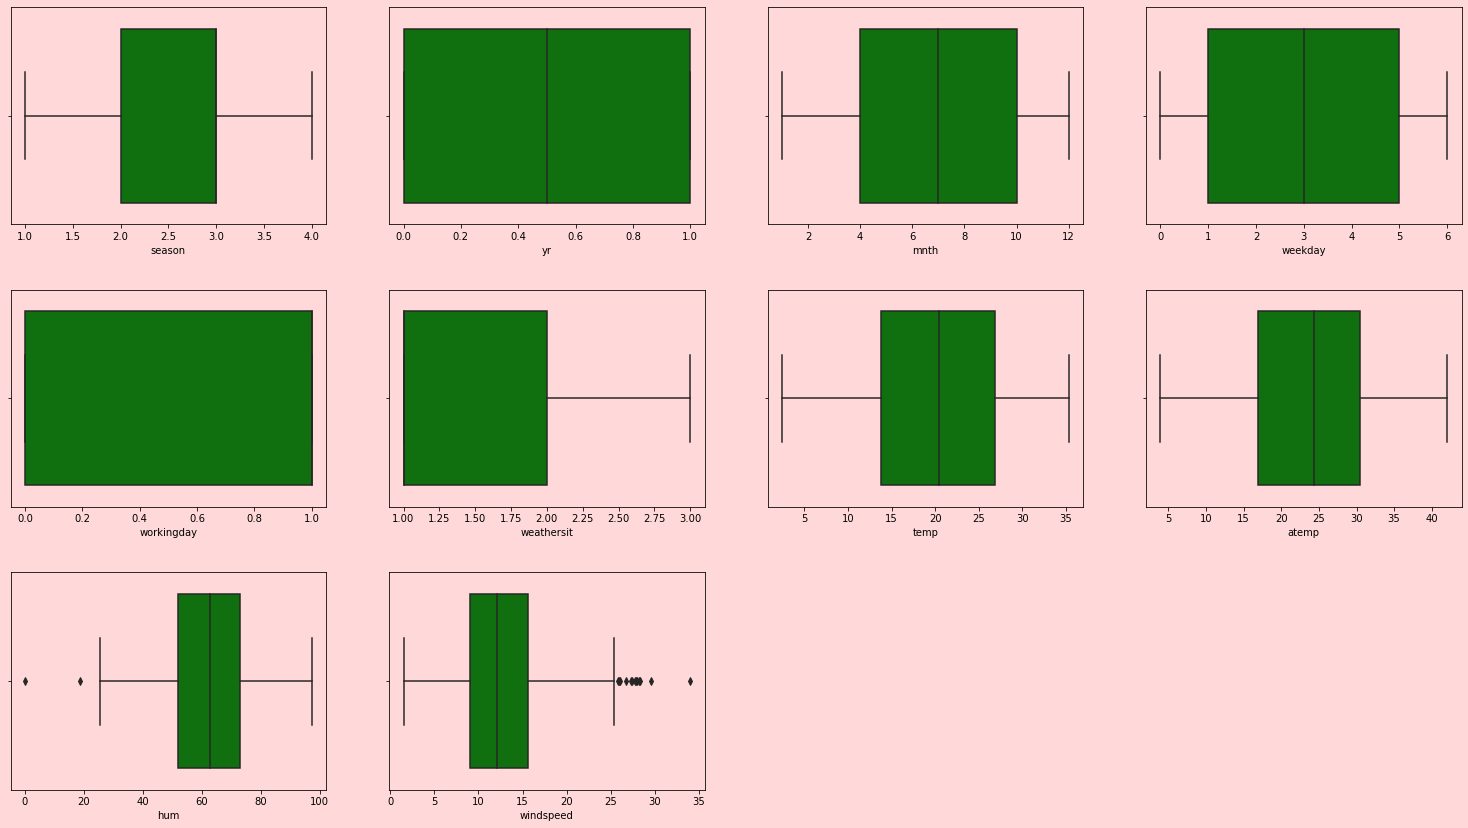

In [10]:
#Creating subplots
fig = plt.figure(figsize=(26,30))
spec = fig.add_gridspec(6,4)
spec.update(wspace=0.2, hspace=0.3)
sec_01 = fig.add_subplot(spec[0,0])
sec_02 = fig.add_subplot(spec[0,1])
sec_03 = fig.add_subplot(spec[0,2])
sec_04 = fig.add_subplot(spec[0,3])
sec_05 = fig.add_subplot(spec[1,0])
sec_06 = fig.add_subplot(spec[1,1])
sec_07 = fig.add_subplot(spec[1,2])
sec_08 = fig.add_subplot(spec[1,3])
sec_09 = fig.add_subplot(spec[2,0])
sec_10 = fig.add_subplot(spec[2,1])
sec_11 = fig.add_subplot(spec[2,2])


# Adding color preference
bg_color = '#ffd9d9'
for selection in [fig, sec_01, sec_02, sec_03, sec_04, sec_05, sec_06, sec_07, sec_08,
                  sec_09, sec_10, sec_11]:
    selection.set_facecolor(bg_color)

# Plotting the graph
sec = [sec_01, sec_02, sec_03, sec_04, sec_05, sec_06, sec_07, sec_08, sec_09, sec_10,sec_11]
cnt = 0
for feature in data:
    if data[feature].dtype=='O' or feature=='cnt':
        continue
    else:
        sns.boxplot(x=data[feature], ax=sec[cnt], color='green')
        cnt+=1
# Removing axis and spines
for sec in [sec_11]:
    for location in ['top', 'right', 'bottom','left']:
        sec.spines[location].set_visible(False)
        sec.xaxis.set_visible(False)
        sec.yaxis.set_visible(False)


###### We can see clear outliers on feature 'hum' and 'windspeed'

Text(0.5, 1.0, 'DISTRIBUTION BEFORE OUTLIER REMOVAL - WINDSPEED')

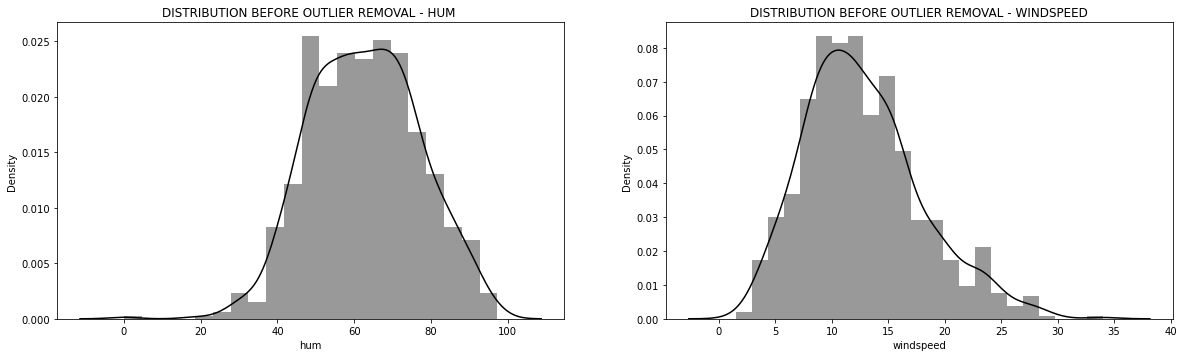

In [11]:
# Removing the data above 99% in upper fence of annual income

# Distribution plot before outlier removal
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
ax = sns.distplot(data['hum'], color='black')
ax.set_title('DISTRIBUTION BEFORE OUTLIER REMOVAL - HUM ')

plt.subplot(2,2,2)
ax = sns.distplot(data['windspeed'], color='black')
ax.set_title('DISTRIBUTION BEFORE OUTLIER REMOVAL - WINDSPEED')


###### We can see 'windspeed' and 'hum' is left skewed

#### OUTLIER TRATMENT

In [12]:
outlier_feature_moretha2=['hum','windspeed']
for feature in outlier_feature_moretha2:
    if data[feature].dtype!='O' and len(data[feature].unique())>2:
        lower_quartile = data[feature].quantile(0.25)
        upper_quartile = data[feature].quantile(0.75)
        IQR = upper_quartile - lower_quartile
        lower_fence = lower_quartile - (1.5*IQR)
        upper_fence = upper_quartile + (1.5*IQR)
        
        data[feature] = np.where(data[feature]>upper_fence, 
                                upper_fence, 
                                data[feature])
        
        data[feature] = np.where(data[feature]<lower_fence,
                               lower_fence,
                               data[feature])

Text(0.5, 1.0, 'DISTRIBUTION AFTER OUTLIER REMOVAL - WINDSPEED')

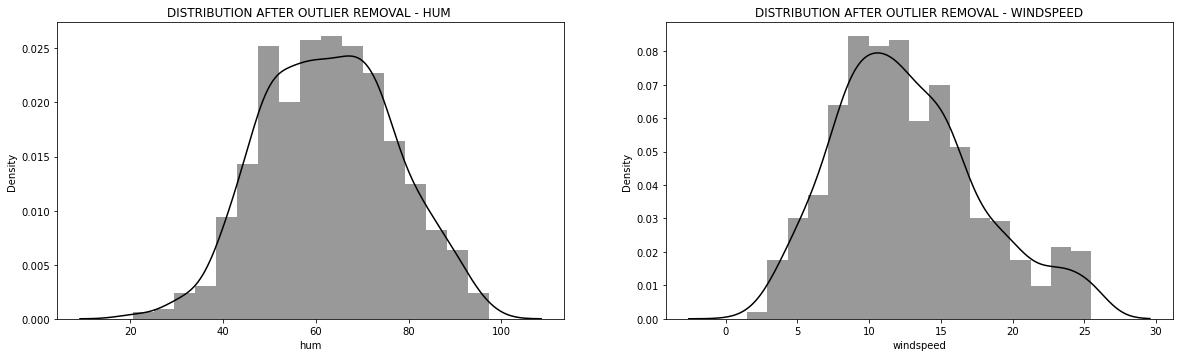

In [13]:

plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
ax = sns.distplot(data['hum'], color='black')
ax.set_title('DISTRIBUTION AFTER OUTLIER REMOVAL - HUM ')

plt.subplot(2,2,2)
ax = sns.distplot(data['windspeed'], color='black')
ax.set_title('DISTRIBUTION AFTER OUTLIER REMOVAL - WINDSPEED')

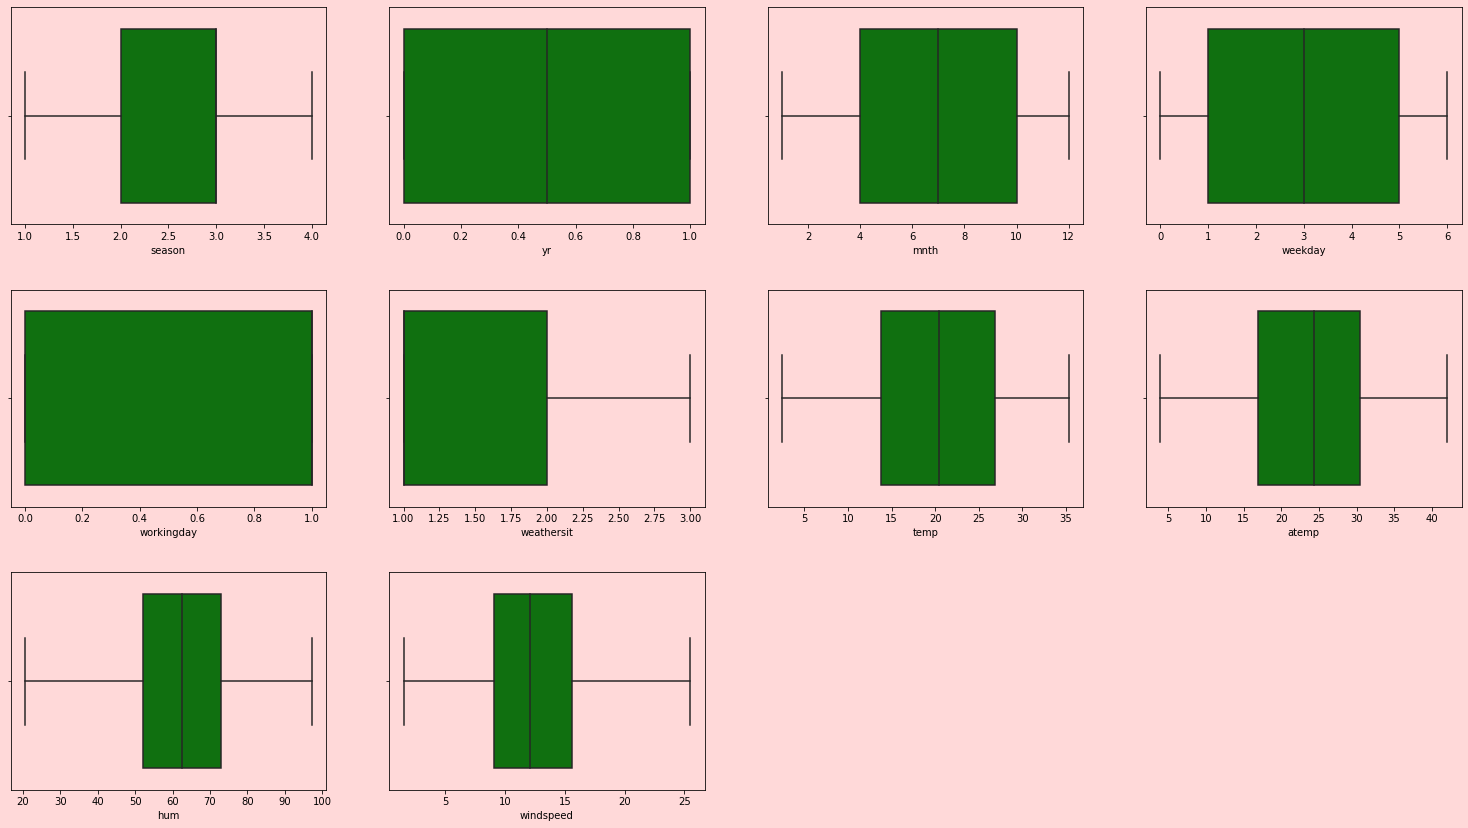

In [14]:
#Creating subplots
fig = plt.figure(figsize=(26,30))
spec = fig.add_gridspec(6,4)
spec.update(wspace=0.2, hspace=0.3)
sec_01 = fig.add_subplot(spec[0,0])
sec_02 = fig.add_subplot(spec[0,1])
sec_03 = fig.add_subplot(spec[0,2])
sec_04 = fig.add_subplot(spec[0,3])
sec_05 = fig.add_subplot(spec[1,0])
sec_06 = fig.add_subplot(spec[1,1])
sec_07 = fig.add_subplot(spec[1,2])
sec_08 = fig.add_subplot(spec[1,3])
sec_09 = fig.add_subplot(spec[2,0])
sec_10 = fig.add_subplot(spec[2,1])
sec_11 = fig.add_subplot(spec[2,2])


# Adding color preference
bg_color = '#ffd9d9'
for selection in [fig, sec_01, sec_02, sec_03, sec_04, sec_05, sec_06, sec_07, sec_08,
                  sec_09, sec_10, sec_11]:
    selection.set_facecolor(bg_color)

# Plotting the graph
sec = [sec_01, sec_02, sec_03, sec_04, sec_05, sec_06, sec_07, sec_08, sec_09, sec_10,sec_11, 
       ]
cnt = 0
for feature in data:
    if data[feature].dtype=='O' or feature=='cnt':
        continue
    else:
        sns.boxplot(x=data[feature], ax=sec[cnt], color='green')
        cnt+=1
# Removing axis and spines
for sec in [sec_11]:
    for location in ['top', 'right', 'bottom','left']:
        sec.spines[location].set_visible(False)
        sec.xaxis.set_visible(False)
        sec.yaxis.set_visible(False)


###### As shown there are NO OUTLIERS

#### CHECK THE NUMBER OF UNIQUE VALUES 
We are checking unique values as we found that the data type of our features are numerical .But we need to identify which among them is continuous numerical feature as we can not apply Multiple Linear Regression on categorical features.

In [15]:
data.nunique()

season          4
yr              2
mnth           12
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           593
windspeed     637
cnt           695
dtype: int64

In [16]:
rows, columns = data.shape
print(f'The dataset has {rows} rows and {columns} columns including target variable ')


print(f'The target variable is {data.columns[-1]}')

The dataset has 730 rows and 11 columns including target variable 
The target variable is cnt


In [17]:
likely_cat = {}
categorical_feature=[]
numerical_feature=[]
for var in data.columns:
    likely_cat[var] = 1.*data[var].nunique()/data[var].count() < 0.05
for key,value in likely_cat.items():
    if value == True:
        if key != 'cnt':  ##exclude target variable  
            categorical_feature.append(key)
    else:
        if key != 'cnt':  ###exclude target variable 
            numerical_feature.append(key)

print(f'{categorical_feature} are categorical features')
print(f'{numerical_feature} are numerical features')


['season', 'yr', 'mnth', 'weekday', 'workingday', 'weathersit'] are categorical features
['temp', 'atemp', 'hum', 'windspeed'] are numerical features


In [18]:
# Convert to 'category' data type
data['season']=data['season'].astype('category')
data['mnth']=data['mnth'].astype('category')
data['weekday']=data['weekday'].astype('category')
data['weathersit']=data['weathersit'].astype('category')
data.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)
data.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'},inplace = True)
data.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'},inplace = True)
data.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)
data.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,mon,1,good,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,tue,1,good,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,wed,1,good,9.305237,11.46350,43.6957,12.522300,1600


###### NOTE : We didnt convert 'yr' and 'workingday'  with string values as we dont want get_dummies to create dummy. Because both the features have 2 values unique which makes encoding these two features of no significanace.

###### VISUALISING NUMERICAL AND CATEGORICAL FEATURE

###### BIVARIATE ANALYSIS 

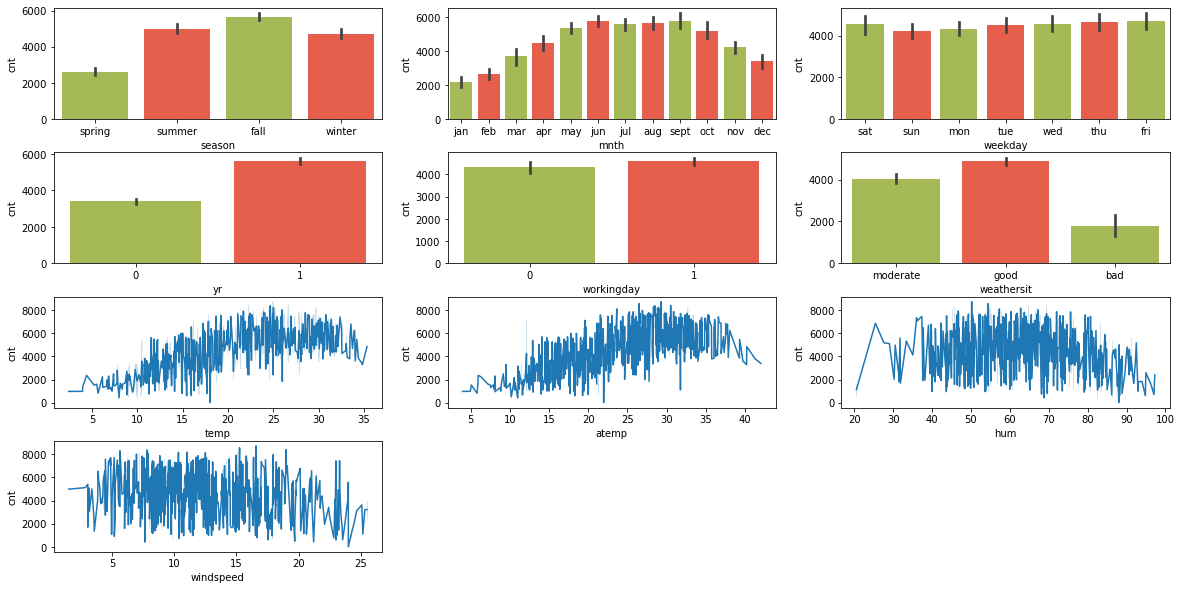

In [19]:
#Creating plots
fig = plt.figure(figsize=(20,10))
spec = fig.add_gridspec(4,3)
spec.update(wspace=0.2, hspace=0.3)
sec_01 = fig.add_subplot(spec[0,0])
sec_02 = fig.add_subplot(spec[0,1])
sec_03 = fig.add_subplot(spec[0,2])
sec_04 = fig.add_subplot(spec[1,0])
sec_05 = fig.add_subplot(spec[1,1])
sec_06 = fig.add_subplot(spec[1,2])
sec_07 = fig.add_subplot(spec[2,0])
sec_08 = fig.add_subplot(spec[2,1])
sec_09 = fig.add_subplot(spec[2,2])
sec_10 = fig.add_subplot(spec[3,0])






# Plotting the graph
sec = [sec_01, sec_02, sec_03, sec_04,sec_05,sec_06]
num_sec = [sec_07, sec_08, sec_09, sec_10]

cnt = 0
for feature in ['season', 'mnth', 'weekday', 'yr','workingday','weathersit']:
    sns.barplot(data =data, 
                x=data[feature],
                 y='cnt', 
                 ax=sec[cnt],
                 palette=['#AECB46', "#FF4C33"])
    cnt+=1
cnt = 0
for feature in ['temp', 'atemp', 'hum', 'windspeed']:
    sns.lineplot(data=data,x=data[feature],
                 y='cnt', 
                 ax=num_sec[cnt],
                 palette=['#AECB46', "#FF4C33"])
    cnt+=1


plt.show()

###### INFERENCE OF BIVARIATE
- Demand is spiked up for every fall and summer season
- Greater demand in 2019 than 2018
- Slight higher when the day is working day
- May to Sept  there is increase in demand for bikes 
- All days of week show almost similar behaviour on demand of bikes
- When the weather is good the demand is clearly way higher as it is convienent to ride a bike in good weather
- There is increase in demand as atemp is higher
- There is dip in demand when humidity and windspeed is higher



##### MULTIVARIATE ANALYSIS

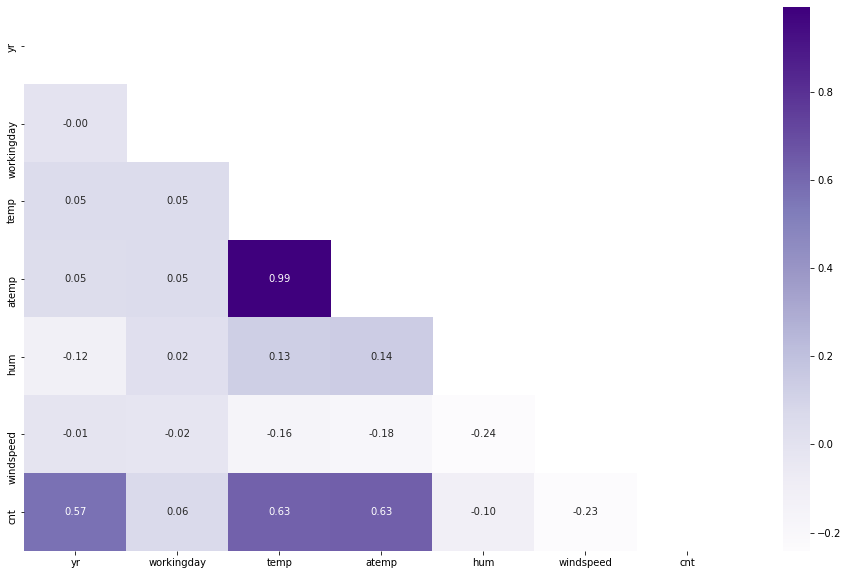

In [20]:
corr = data.corr()
mask = np.triu(corr)
plt.figure(figsize=(16,10))
sns.heatmap(corr, 
            annot=True , 
            fmt='.2f', 
            mask=mask, 
            cmap='Purples')
plt.show()

In [ ]:
#create pairplot
pairplotconti= data[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']]

sns.pairplot(pairplotconti, diag_kind='kde')
plt.show()

###### INFERENCE OF MULTIVARIATE
- There is strong correlation between cnt and temp and cnt and atemp 
- There is strong correlation between atemp and temp

## DATA PREPARATION AND MODEL BUILDING 

### DATA TRANSFORMATION AND SCALING AND TRAIN TEST SPLIT 

In [ ]:
data = pd.get_dummies(data, drop_first=True)
data.info()

In [ ]:
#After doing the encoding 

rows, columns = data.shape
print(f'The encoded feature dataset has {rows} rows and {columns} columns')

#### SPLITING DATASET 

In [ ]:


# We should specify 'random_state' so that the train and test data set always have the same rows, respectively

np.random.seed(0)
data_train, data_test = train_test_split(data, train_size = 0.70, test_size = 0.30, random_state = 100)

In [ ]:
##test and train shape check 
rows, columns = data_train.shape
print(f'The encoded feature dataset has {rows} rows and {columns} columns')
rows, columns = data_test.shape
print(f'The encoded feature dataset has {rows} rows and {columns} columns')

#### RESCALING THE DATASET

In [ ]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables

scaler = MinMaxScaler()
data_train[numerical_feature] = scaler.fit_transform(data_train[numerical_feature])

data_train.head()

###### DIVIDING INTO X AND Y SETS FOR MODEL BUILDING

In [ ]:
y_train = data_train.pop('cnt')
X_train = data_train


###### MODEL BUILDING

In [ ]:
# Build a Lienar Regression model using SKLearn for RFE
lr = LinearRegression()
lr.fit(X_train,y_train)

In [ ]:
#Cut down number of features to 15 using automated approach
rfe = RFE(lr,15)
rfe.fit(X_train,y_train)

In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

###### MANUAL ELIMINATION

In [ ]:
#Function to build a model using statsmodel api - Takes the columns to be selected for model as a parameter
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [ ]:
#Function to calculate VIFs and print them -Takes the columns for which VIF to be calcualted as a parameter
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [ ]:
X_train_rfe=X_train.columns[rfe.support_]
print(f'The features supported by rfe {X_train_rfe} and its shape is {X_train_rfe.shape}')

There are 15 features as listed above picked up by RFE 

### MODEL 1

In [ ]:
##selected RFE values 
cols_1=X_train_rfe
X_train_rfe = X_train[cols_1]

In [ ]:
##model 1 
build_model(cols_1)
get_vif(cols_1)

Removing 'mnth_jan' - <b>High p value and low  VIF</b>

### MODEL 2

In [ ]:
X_train_rfe= X_train_rfe.drop(["mnth_jan"], axis = 1)
X_train_rfe_copy=X_train_rfe

In [ ]:
build_model(X_train_rfe.columns)
get_vif(X_train_rfe.columns)

Removing 'weekday_sun' - <b>High p value ,Low VIF</b>

### MODEL 3

In [ ]:
X_train_rfe= X_train_rfe.drop(["weekday_sun"], axis = 1)

In [ ]:
build_model(X_train_rfe.columns)
get_vif(X_train_rfe.columns)

Removing 'season_spring' - <b> High p value and low VIF </b>

### MODEL 4

In [ ]:
X_train_rfe= X_train_rfe.drop(["season_spring"], axis = 1)

In [ ]:
build_model(X_train_rfe.columns)
get_vif(X_train_rfe.columns)

Removing 'hum' - <b> low p value ,High VIF</b>

### MODEL 5

In [ ]:
X_train_rfe= X_train_rfe.drop(["hum"], axis = 1)

In [ ]:
build_model(X_train_rfe.columns)
get_vif(X_train_rfe.columns)

Removing 'mnth_jul' - <b>High p value ,low VIF</b>

### MODEL 6

In [ ]:
X_train_rfe= X_train_rfe.drop(["mnth_jul"], axis = 1)

In [ ]:
build_model(X_train_rfe.columns)
get_vif(X_train_rfe.columns)

Removing 'weathersit_good' - <b> Low p value and High VIF</b>

### MODEL 7

In [ ]:
X_train_rfe= X_train_rfe.drop(["weathersit_good"], axis = 1)


In [ ]:
final_model=build_model(X_train_rfe.columns)
get_vif(X_train_rfe.columns)

Here 
- VIF is below 5 - accepted. 
- p-value for all the features is  0.0 - accepted 
- R2 is 0.781 - a good value 
- F-stat - 210 which is high accepted 
- P(F-stat) is almost 0 - accepted 

In [ ]:
#build the finalmodel using sklearn
cols =X_train_rfe.columns

#Build a model with above columns

lr = LinearRegression()
lr.fit(X_train[cols],y_train)
print(lr.intercept_,lr.coef_)

#### EQUATION

#### cnt = 714.8717 + 2075.5328 * yr+418.4003* workingday + 4794.5384 * temp -1191.6454 * windspeed + 765.2942 * season_summer + 1022.4238 * season_winter  +  760.3812* mnth_sept +  508.8859*weekday_sat -585.2222 * weathersit_moderate

##### RESIDUAL ANALYSIS AND PREDICTION

In [ ]:
y_train_cnt = lr.predict(X_train[cols])

In [ ]:
# Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_cnt, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

#### Actual and predicted is almost same - The model is good 

In [ ]:
r2_score(y_train,y_train_cnt)

#### R2 score is almost same as model R2 score 

##### SUMMARY OF ACCURACY OF TRAIN MODEL 
- Actual and predicted is almost same - The model is good
- R2 score of y_train vs y_train_cnt is almost same as model R2 score

In [ ]:
##scale variables of numerical 

### no fit only transform on test data
data_test[numerical_feature] = scaler.transform(data_test[numerical_feature])

In [ ]:
y_test = data_test.pop('cnt')
X_test = data_test

In [ ]:
y_test_cnt = lr.predict(X_test[cols])

In [ ]:
c = [i for i in range(0,len(X_test),1)]
plt.plot(c,y_test, color="blue")
plt.plot(c,y_test_cnt, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

The y_test and y_test_cnt are almost same 

In [ ]:
r2_score(y_test,y_test_cnt)

##### SUMMARY OF ACCURACY OF TEST SET
- Variance of the residuals (error terms) is constant across predictions. i.e error term does not vary much as the value of the predictor variable changes.
- Actual and predicted is almost same on test data 
- R2 score of y_test vs y_test_cnt is almost same but has slight variation of .02 which is exceptable when compared with R2 score of model


In [ ]:
print ("This is difference between train and test r2 score {0:.2f} which is approximately 2% difference which shows the model is good and since difference is less which says the model is not overfitting as accuracy of train and test data r2 score is very less can be considered negligible.Hence I conclude the model is best fit possible".format(r2_score(y_train,y_train_cnt)-r2_score(y_test,y_test_cnt))) 

R2 score is almost same as model R2 score

In [ ]:
fig = plt.figure()
plt.scatter(y_test, y_test_cnt)
fig.suptitle('y_test vs y_test_cnt', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_cnt', fontsize = 16)

Variance of the residuals (error terms) is constant across predictions. i.e error term does not vary much as the value of the predictor variable changes.

### CHECK MULTIPLE LINEAR REGERESSION ASSUMPTION

#### MULTICOLINEARITY

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train[cols].corr(),annot = True, cmap="RdYlGn")
plt.show()

Collinearity is less and correlation  has dropped

####  HOMOSCEDASITY 

In [ ]:
fig = plt.figure(figsize=(14,5))
sns.regplot(y_test_cnt,y_test-y_test_cnt, color="blue", marker='o')
fig.suptitle('Homoscedasity', fontsize=20)              # Plot heading 
plt.xlabel('ypred', fontsize=18)                      # X-label
plt.ylabel('Error -ycnt-ytest', fontsize=16)

Error terms are randomly distributed and there is no pattern which means the output is explained well by the model and there are no other parameters that can explain the model better.

#### LINEARITY 

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(24, 14))
k=0
for i in range(3):
    for j in range(3):
        if k<9:
              sns.regplot(x = X_train[cols[k]], y = y_train,ax=ax[i][j])
        k+=1
plt.show()

The is linear relationship between dependent variable (cnt) to all model selected independent variables as shown.

#### NORMALITY

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

- Errors are normally distributed is indicated by mean is 0 
- Error terms are randomly distributed and there is no pattern which means the output is explained well by the model and there are no other parameters that can explain the model better.

#### INFERENCES ON ASSUMPTION
All the 4 assumption are abided by the data

#### INTERPRETATION 
 - The top 3 influence on the bike booking /demand 
    - temp : A coefficient value of 4794.5384  indicated that a unit increase in <b>temp</b> variable increases the bike demand by same number 
    - yr : A coefficient value of 2075.5328   indicated that a unit increase in <b>yr</b> variable increases the bike demand by same number 
    - season_winter : A coefficient value of 1022.4238    indicated that a unit increase in <b>season_winter</b>  variable increases the bike demand by same number 

<b>NOTE:</b>

- season- 1:"spring", 2:"summer", 3:"fall", 4:"winter"
- mnth - 1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'
- weekday - 0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'
- weathersit -1:'good',2:'moderate',3:'bad',4:'severe'